# Vectorizing backpropagation (in theory)

Now that we understand how to work with the `Tensor` class in practice, it's high time that we pop the hood and remove all the screws. 

I have some good news and some bad news for you. The good news is that regarding the computational graph structure, `Tensor` works the same as `Scalar`. Our vectorized computatinal graphs are made up of `Tensor` nodes and `Edge` connections.

Bad news is that derivatives are way more complex than for our scalar counterparts. We need to significantly up our linear algebra game to keep the pace.

Let's get started.

## Vector-scalar graphs

As usual, let's see the simplest possible example: the dot product. For any $ \mathbf{x}, \mathbf{y} \in \mathbb{R}^n $, its dot product is defined by

$$
f = \mathbf{x} \cdot \mathbf{y} = \sum_{i=1}^{n} x_i y_i \in \mathbb{R}.
$$

In other words, we input two vectors (of the same dimensions) and receive a scalar value. Here's the graph:

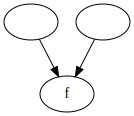

In [2]:
from graphviz import Digraph

graph = Digraph()
graph.node("a", "𝐱")
graph.node("b", "𝐲")
graph.node("c", "f")
graph.edges(["ac", "bc"])

graph

Nothing special so far. Now, let's calculate the derivative with backwards-mode differentiation! Following {ref}`what we've learned so far <section:computational-graphs/backwards-pass/backpropagation>`, this is the graph we need to fill with exact values:

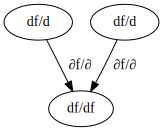

In [3]:
digraph = Digraph()

nodes = ["𝐱", "𝐲", "f"]
edges = [("𝐱", "f"), ("𝐲", "f")]

for v in nodes:
    digraph.node(v, f"df/d{v}")

for u, v in edges:
    digraph.edge(u, v, f"∂{v}/∂{u}")

digraph

But what on earth do the symbols $ \frac{df}{d\mathbf{x}} $ and $ \frac{\partial f}{\partial \mathbf{x}} $ mean? Can we take the derivative with respect to a vector?

Not so surprisingly, these represent

$$
\frac{df}{d\mathbf{x}} = \bigg( \frac{df}{dx_1}, \dots, \frac{df}{dx_n} \bigg)
$$

and

$$
\frac{\partial f}{\partial \mathbf{x}} = \bigg( \frac{\partial f}{\partial x_1}, \dots, \frac{\partial f}{\partial x_n} \bigg),
$$

that is, we compressed a vector of derivatives into a single symbol. (In this example, the global derivative $ \frac{df}{d\mathbf{x}} $ and the local derivative $ \frac{\partial f}{\partial \mathbf{x}} $ coincide. This won't be always the case.)

For the dot product, the vectorized derivatives are

$$
\begin{align*}
\frac{df}{d\mathbf{x}} = \frac{\partial f}{\partial \mathbf{x}} &= (y_1, \dots, y_n), \\
\frac{df}{d\mathbf{y}} = \frac{\partial f}{\partial \mathbf{y}} &= (x_1, \dots, x_n).
\end{align*}
$$

Sounds simple enough. What about vector-vector functions?

## Vector-vector graphs

Let's dial the difficulty up just a notch and consider the vector addition: for any $ \mathbf{x}, \mathbf{y} \in \mathbb{R}^n $, the expression

$$
\mathbf{f} = \mathbf{x} + \mathbf{y}
$$

defines the same V-shaped computational graph as dot product:

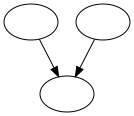

In [4]:
graph = Digraph()
graph.node("a", "𝐱")
graph.node("b", "𝐲")
graph.node("c", "𝐟")
graph.edges(["ac", "bc"])

graph

The derivative graph also looks the same, with one major difference: there are menacing vector-vector derivatives.

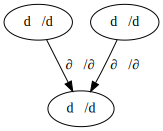

In [5]:
digraph = Digraph()

nodes = ["𝐱", "𝐲", "𝐟"]
edges = [("𝐱", "𝐟"), ("𝐲", "𝐟")]

for v in nodes:
    digraph.node(v, f"d𝐟/d{v}")

for u, v in edges:
    digraph.edge(u, v, f"∂{v}/∂{u}")

digraph

Fear not. It's a similar notational trick, encoding a *matrix* of derivatives:

$$
\frac{\partial \mathbf{f}}{\partial \mathbf{x}} = \begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \dots & \frac{\partial f_1}{\partial x_n} \\
\frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \dots & \frac{\partial f_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial f_n}{\partial x_1} & \frac{\partial f_n}{\partial x_2} & \dots & \frac{\partial f_n}{\partial x_n} \\
\end{bmatrix}.
$$

The matrix $ \frac{\partial \mathbf{f}}{\partial \mathbf{x}} $ is called the *Jacobian* of $ \mathbf{f} $. It's an essential concept of differential calculus, and we'll frequently encounter it throughout our journey.

We can use a similar notation for the global derivatives as well:

$$
\frac{d \mathbf{f}}{d \mathbf{x}} = \begin{bmatrix}
\frac{d f_1}{d x_1} & \frac{d f_1}{d x_2} & \dots & \frac{d f_1}{d x_n} \\
\frac{d f_2}{d x_1} & \frac{d f_2}{d x_2} & \dots & \frac{d f_2}{d x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{d f_n}{d x_1} & \frac{d f_n}{d x_2} & \dots & \frac{d f_n}{d x_n} \\
\end{bmatrix}.
$$

Following our notational conventions, let's call $ \frac{\partial \mathbf{f}}{\partial \mathbf{x}} $ the *local* Jacobian, while $ \frac{d\mathbf{f}}{d\mathbf{x}} $ the *global* Jacobian.

### The vectorized chain rule

Now that we understand the building blocks of vectorized computational graphs, let's focus on the lead actor: the chain rule. Like always, it's best to study it through an example. You already know the drill by now, so let's start with the graph right away.

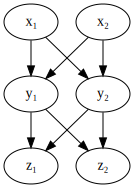

In [11]:
digraph = Digraph()

nodes = ["x₁", "x₂", "y₁", "y₂", "z₁", "z₂"]
edges = [("x₁", "y₁"), ("x₁", "y₂"),
         ("x₂", "y₁"), ("x₂", "y₂"),
         ("y₁", "z₁"), ("y₁", "z₂"),
         ("y₂", "z₁"), ("y₂", "z₂")]

for v in nodes:
    digraph.node(v)

digraph.edges(edges)

digraph

Let's compute the derivative! Right away, we hit a snag. Unlike our previous examples, there's not one, but two terminal nodes! Thus, we have two derivative graphs to fill up with values.

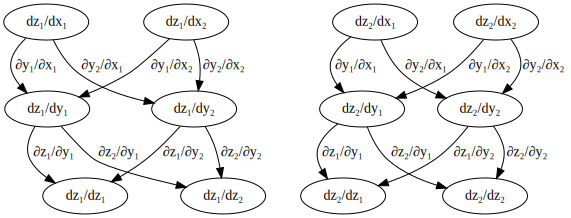

In [10]:
digraph = Digraph()

nodes = ["x₁", "x₂", "y₁", "y₂", "z₁", "z₂"]
edges = [("x₁", "y₁"), ("x₁", "y₂"),
         ("x₂", "y₁"), ("x₂", "y₂"),
         ("y₁", "z₁"), ("y₁", "z₂"),
         ("y₂", "z₁"), ("y₂", "z₂")]
offset = " "

for v in nodes:
    digraph.node(v, label=f"dz₁/d{v}")
    digraph.node(v + offset, label=f"dz₂/d{v}")

for u, v in edges:
    digraph.edge(u, v, label=f"∂{v}/∂{u}")
    digraph.edge(u + offset, v + offset, label=f"∂{v}/∂{u}")

digraph

According to what we've learned when {ref}`we introduced backpropagation <section:computational-graphs/backwards-pass/backpropagation>`, the first graph gives

$$
\begin{align*}
\frac{dz_1}{dx_1} &= \frac{dz_1}{dy_1} \frac{\partial y_1}{\partial x_1} + \frac{dz_1}{dy_2} \frac{\partial y_2}{\partial x_1}, \\
\frac{dz_1}{dx_2} &= \frac{dz_1}{dy_1} \frac{\partial y_1}{\partial x_2} + \frac{dz_1}{dy_2} \frac{\partial y_2}{\partial x_2},
\end{align*}
$$

while the second graph gives

$$
\begin{align*}
\frac{dz_2}{dx_1} &= \frac{dz_2}{dy_1} \frac{\partial y_1}{\partial x_1} + \frac{dz_2}{dy_2} \frac{\partial y_2}{\partial x_1}, \\
\frac{dz_2}{dx_2} &= \frac{dz_2}{dy_1} \frac{\partial y_1}{\partial x_2} + \frac{dz_2}{dy_2} \frac{\partial y_2}{\partial x_2}.
\end{align*}
$$

So many symbols and operations; it's not the most pleasant sights to look at. Do you recognize a pattern? Let me rewrite the above expressions in a matrix form:

$$
\begin{bmatrix}
\frac{dz_1}{dx_1} & \frac{dz_1}{dx_2} \\
\frac{dz_2}{dx_1} & \frac{dz_2}{dx_2} \\
\end{bmatrix} = \begin{bmatrix}
\sum_{k=1}^2 \frac{dz_1}{dy_k} \frac{\partial y_k}{\partial x_1} & \sum_{k=1}^2 \frac{dz_1}{dy_k} \frac{\partial y_k}{\partial x_2} \\
\sum_{k=1}^2 \frac{dz_2}{dy_k} \frac{\partial y_k}{\partial x_1} & \sum_{k=1}^2 \frac{dz_2}{dy_k} \frac{\partial y_k}{\partial x_2} \\
\end{bmatrix}.
$$

In other words,

$$
\frac{d\mathbf{z}}{d\mathbf{x}} = \frac{d\mathbf{z}}{d\mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{x}}
$$

holds! With one brilliant stroke of linear algebra, we've contracted our computational graph from

In [ ]:
digraph = Digraph()

nodes = ["x₁", "x₂", "y₁", "y₂", "z₁", "z₂"]
edges = [("x₁", "y₁"), ("x₁", "y₂"),
         ("x₂", "y₁"), ("x₂", "y₂"),
         ("y₁", "z₁"), ("y₁", "z₂"),
         ("y₂", "z₁"), ("y₂", "z₂")]

for v in nodes:
    digraph.node(v)

digraph.edges(edges)

digraph

to

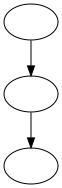

In [14]:
digraph = Digraph()

nodes = ["𝐱", "𝐲", "𝐳"]
edges = [("𝐱", "𝐲"), ("𝐲", "𝐳")]

for v in nodes:
    digraph.node(v)

for u, v in edges:
    digraph.edge(u, v)

digraph

and its derivative graphs from

In [ ]:
digraph = Digraph()

nodes = ["x₁", "x₂", "y₁", "y₂", "z₁", "z₂"]
edges = [("x₁", "y₁"), ("x₁", "y₂"),
         ("x₂", "y₁"), ("x₂", "y₂"),
         ("y₁", "z₁"), ("y₁", "z₂"),
         ("y₂", "z₁"), ("y₂", "z₂")]
offset = " "

for v in nodes:
    digraph.node(v, label=f"dz₁/d{v}")
    digraph.node(v + offset, label=f"dz₂/d{v}")

for u, v in edges:
    digraph.edge(u, v, label=f"∂{v}/∂{u}")
    digraph.edge(u + offset, v + offset, label=f"∂{v}/∂{u}")

digraph

to

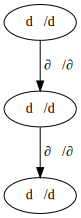

In [13]:
digraph = Digraph()

nodes = ["𝐱", "𝐲", "𝐳"]
edges = [("𝐱", "𝐲"), ("𝐲", "𝐳")]

for v in nodes:
    digraph.node(v, f"d𝐳/d{v}")

for u, v in edges:
    digraph.edge(u, v, f"∂{v}/∂{u}")

digraph

That's a massive improvement! I told you that linear algebra is powerful.